# Transfer Learning for Computer Vision Tutorial

In this tutorial, you will learn how to train a convolutional neural network for image classification using transfer learning. You can read more about the transfer learning at [cs231n notes](https://cs231n.github.io/transfer-learning/)

Quoting these notes,
```
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.
```
These two major transfer learning scenarios look as follows:

* **Finetuning the convnet:** Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.
* **ConvNet as fixed feature extractor:** Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

## Load Data

We will use torchvision and torch.utils.data packages for loading the data.

The problem we’re going to solve today is to train a model to classify **ants** and **bees**. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

**NOTE**

Download the data from [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip) and extract it to the current directory.

In [2]:
%%bash
wget -c https://download.pytorch.org/tutorial/hymenoptera_data.zip
unzip ./hymenoptera_data.zip

Archive:  ./hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/1473

--2020-06-25 16:27:28--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.180.39, 13.224.180.11, 13.224.180.73, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.180.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: 'hymenoptera_data.zip’

     0K .......... .......... .......... .......... ..........  0% 33.9M 1s
    50K .......... .......... .......... .......... ..........  0% 23.5M 2s
   100K .......... .......... .......... .......... ..........  0% 21.9M 2s
   150K .......... .......... .......... .......... ..........  0% 8.84M 3s
   200K .......... .......... .......... .......... ..........  0% 73.3M 2s
   250K .......... .......... .......... .......... ..........  0% 17.5M 2s
   300K .......... .......... .......... .......... ..........  0% 24.8M 2s
   350K .......... .......... .......... .......... ..........  

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Visualize a few images

Let’s visualize a few training images so as to understand the data augmentations.

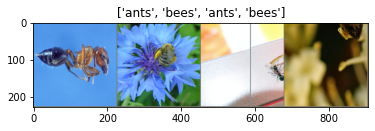

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

Now, let’s write a general function to train a model. Here, we will illustrate:

* Scheduling the learning rate
* Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from ``torch.optim.lr_scheduler``.

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions

Generic function to display predictions for a few images

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the convnet

Load a pretrained model and reset final fully connected layer.

In [11]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home1/yanp/.cache/torch/checkpoints/resnet18-5c106cde.pth
52.5%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8524 Acc: 0.5861
val Loss: 0.2773 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.6610 Acc: 0.7295
val Loss: 0.4816 Acc: 0.8235

Epoch 2/24
----------
train Loss: 0.5577 Acc: 0.8033
val Loss: 0.3580 Acc: 0.8627

Epoch 3/24
----------
train Loss: 0.4494 Acc: 0.7992
val Loss: 0.3793 Acc: 0.8627

Epoch 4/24
----------
train Loss: 0.4300 Acc: 0.8033
val Loss: 0.3753 Acc: 0.8301

Epoch 5/24
----------
train Loss: 0.5442 Acc: 0.7910
val Loss: 0.5120 Acc: 0.8562

Epoch 6/24
----------
train Loss: 0.3625 Acc: 0.8689
val Loss: 0.4079 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.4670 Acc: 0.8197
val Loss: 0.3781 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.3121 Acc: 0.8689
val Loss: 0.3133 Acc: 0.8758

Epoch 9/24
----------
train Loss: 0.3094 Acc: 0.8607
val Loss: 0.2704 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.3414 Acc: 0.8525
val Loss: 0.2711 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.2315 Acc: 0.8975
val Loss: 0.2927 Acc: 0.9150

Ep

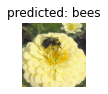

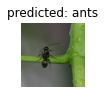

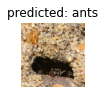

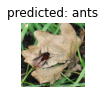

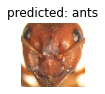

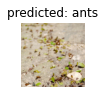

In [14]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need to set ``requires_grad == False`` to freeze the parameters so that the gradients are not computed in ``backward()``.

You can read more about this in the documentation [here](https://pytorch.org/docs/master/notes/autograd.html4).

In [15]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and evaluate

On CPU this will take about half the time compared to previous scenario. This is expected as gradients don’t need to be computed for most of the network. However, forward does need to be computed.

In [16]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5731 Acc: 0.6639
val Loss: 0.2037 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.8047 Acc: 0.6639
val Loss: 0.2694 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.4907 Acc: 0.7787
val Loss: 0.1793 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.3785 Acc: 0.8689
val Loss: 0.1868 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4865 Acc: 0.8115
val Loss: 0.3272 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.4304 Acc: 0.8443
val Loss: 0.1867 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.5062 Acc: 0.7869
val Loss: 0.2885 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3489 Acc: 0.8730
val Loss: 0.1995 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3140 Acc: 0.8689
val Loss: 0.2050 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3400 Acc: 0.8443
val Loss: 0.1954 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3621 Acc: 0.8115
val Loss: 0.2126 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3487 Acc: 0.8648
val Loss: 0.2403 Acc: 0.9281

Ep

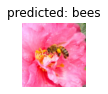

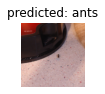

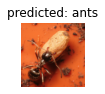

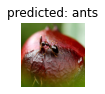

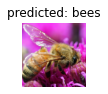

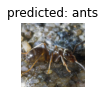

In [17]:
visualize_model(model_conv)

plt.ioff()
plt.show()

If you would like to learn more about the applications of transfer learning, checkout our [Quantized Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html).

[Dynamic Quantization](https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html?highlight=quantized): Quantizing a network means converting it to use a reduced precision integer representation for the weights and/or activations. This saves on model size and allows the use of higher throughput math operations on your CPU or GPU.)

In [18]:
from torch.utils.tensorboard import SummaryWriter
import os

log_dir = os.path.join(os.environ["WORKSPACE_TENSORBOARD"], "runs", "transfer_learning_for_computer_vision_tutorial_exp_1")

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(log_dir)

In [27]:
writer.add_graph(model_conv.to(device), iter(dataloaders["train"]).next()[0].to(device))